In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import os
from utils import ELEMENTS_NAMES, ELEMENTS_UNITS
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
import seaborn as sns
from concurrent.futures import ProcessPoolExecutor, as_completed

figures_dir = "../figures/correlation"

os.makedirs(figures_dir, exist_ok=True)

  0%|          | 0/1508 [00:00<?, ?it/s]

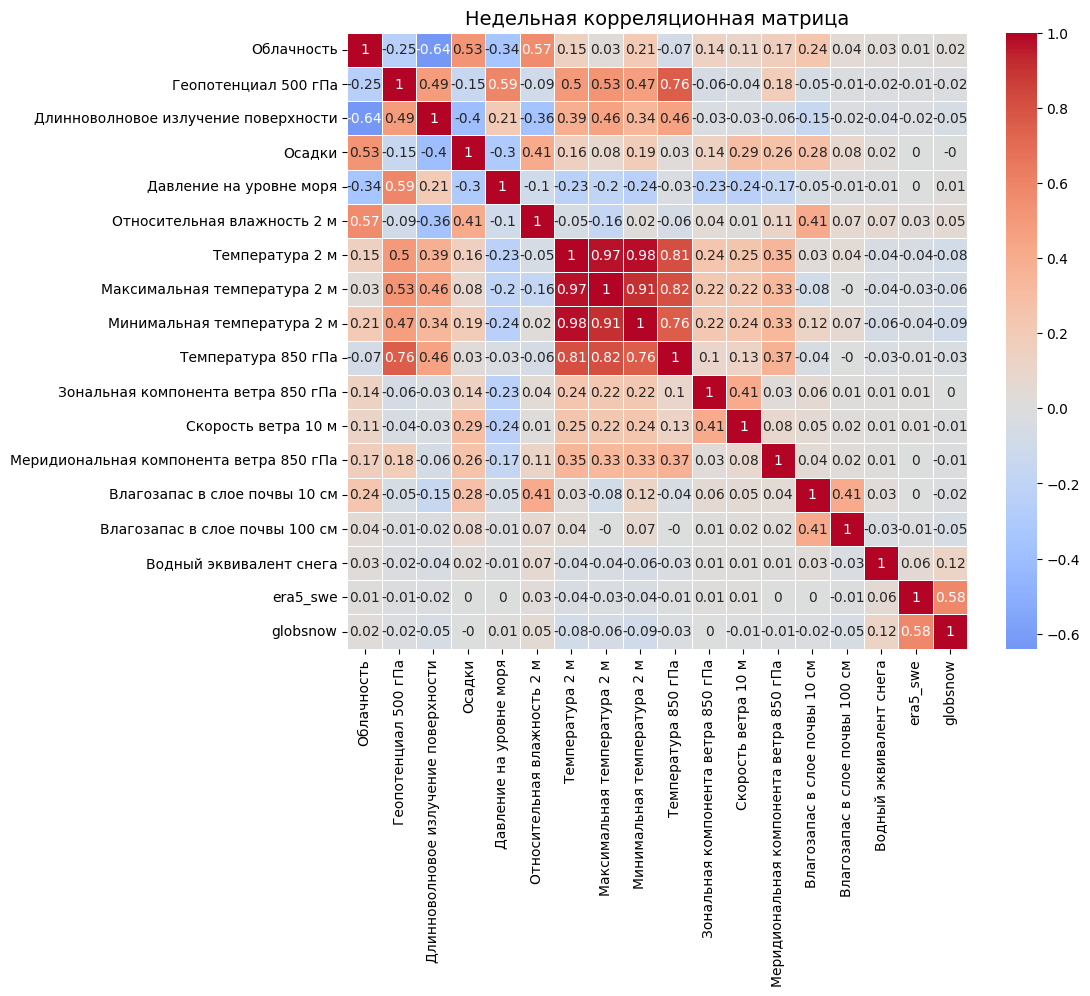

In [2]:
def process_week_pair(year, week):
    try:
        ds1 = xr.open_dataset(f"../data/merge/inmcm_week/{year}{week:02d}.nc", engine="h5netcdf").sel(lead_time=0)
        ds2 = xr.open_dataset(f"../data/merge/inmcm_swe/{year}{week:02d}.nc", engine="h5netcdf").sel(lead_time=0).interp(lat=lat, lon=lon)
        ds3 = xr.open_dataset(f"../data/merge/era5_swe/{year}{week:02d}.nc", engine="h5netcdf").interp(lat=lat, lon=lon).rename({"swe": "era5_swe"})
        ds4 = xr.open_dataset(f"../data/merge/globsnow/{year}{week:02d}.nc", engine="h5netcdf").interp(lat=lat, lon=lon).rename({"swe": "globsnow"})
        merged = xr.merge([ds1, ds2, ds3, ds4], compat="no_conflicts")
        return merged.to_dataframe().drop(columns='lead_time')
    except Exception as e:
        return None

ds = xr.open_dataset(f"../data/merge/inmcm_week/199101.nc", engine="h5netcdf").sel(lead_time=0)
lat, lon = ds.lat.values, ds.lon.values
pairs = list(product(range(1991, 2020), range(1, 53)))
datasets = []

with ProcessPoolExecutor() as executor:
    futures = [executor.submit(process_week_pair, year, week) for year, week in pairs]
    with tqdm(total=len(futures)) as pbar:
        for f in as_completed(futures):
            result = f.result()
            if result is not None:
                datasets.append(result)
            pbar.update(1)

df = pd.concat(datasets)
corr = df[~np.isnan(df["swe"]) & df["swe"] != 0].rename(columns=ELEMENTS_NAMES).corr().round(2)
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Недельная корреляционная матрица", fontsize=14)
plt.savefig(f'{figures_dir}/week.png', dpi=150, bbox_inches='tight')
plt.show()

del df
del datasets

  0%|          | 0/348 [00:00<?, ?it/s]

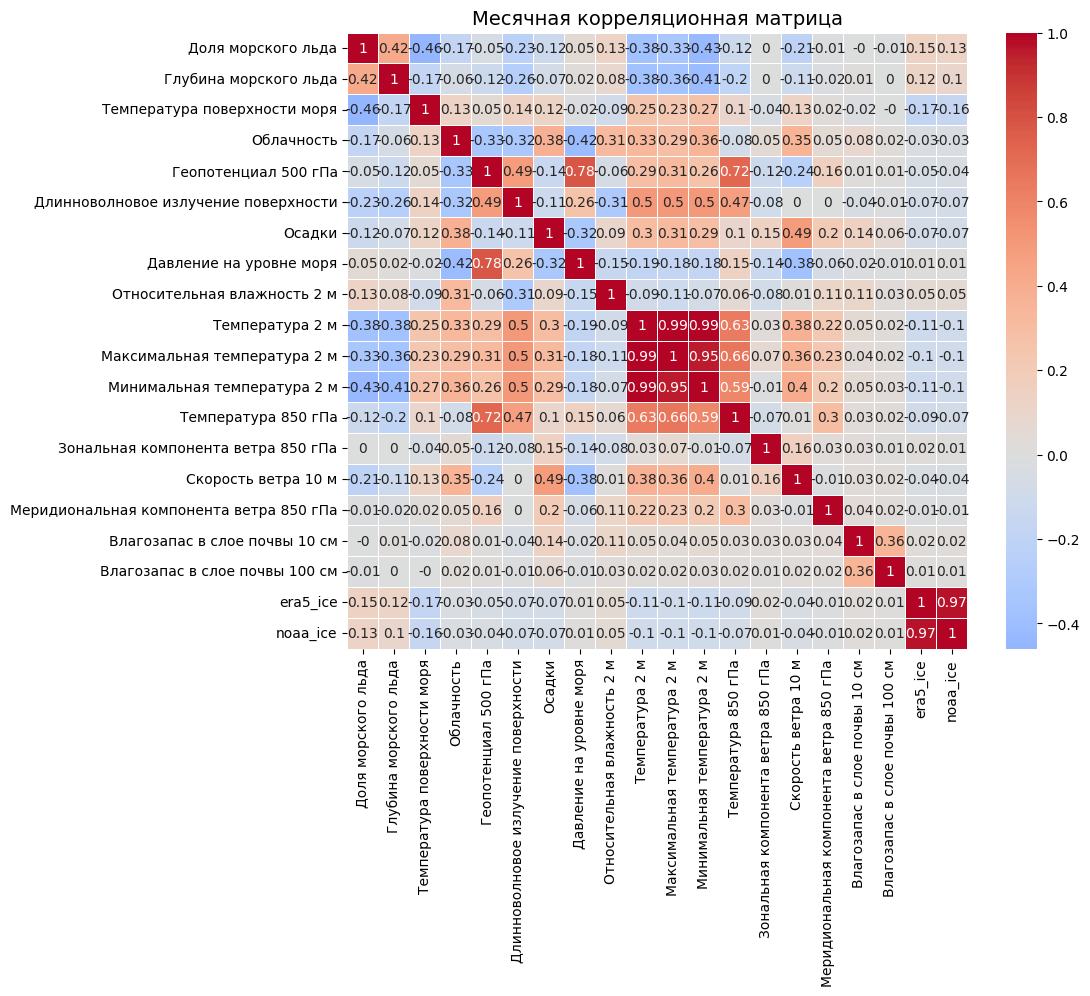

In [3]:
def process_month_pair(year, month):
    try:
        ds1 = xr.open_dataset(f"../data/merge/inmcm_ice/{year}{month:02d}.nc", engine="h5netcdf").sel(lead_time=0)
        ds2 = xr.open_dataset(f"../data/merge/inmcm_month/{year}{month:02d}.nc", engine="h5netcdf").sel(lead_time=0).interp(lat=lat, lon=lon)
        ds3 = xr.open_dataset(f"../data/merge/era5_ice/{year}{month:02d}.nc", engine="h5netcdf").interp(lat=lat, lon=lon).rename({"ice": "era5_ice"})
        ds4 = xr.open_dataset(f"../data/merge/noaa_ice/{year}{month:02d}.nc", engine="h5netcdf").interp(lat=lat, lon=lon).rename({"ice": "noaa_ice"})
        merged = xr.merge([ds1, ds2, ds3, ds4], compat="no_conflicts")
        return merged.to_dataframe().drop(columns='lead_time')
    except Exception as e:
        return None

ds = xr.open_dataset(f"../data/merge/inmcm_ice/199101.nc", engine="h5netcdf").sel(lead_time=0)
lat, lon = ds.lat.values, ds.lon.values
pairs = list(product(range(1991, 2020), range(1, 13)))
datasets = []

with ProcessPoolExecutor() as executor:
    futures = [executor.submit(process_month_pair, year, month) for year, month in pairs]
    with tqdm(total=len(futures)) as pbar:
        for f in as_completed(futures):
            result = f.result()
            if result is not None:
                datasets.append(result)
            pbar.update(1)

df = pd.concat(datasets)
corr = df[~np.isnan(df["aice"]) & df["aice"] != 0].rename(columns=ELEMENTS_NAMES).corr().round(2)
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Месячная корреляционная матрица", fontsize=14)
plt.savefig(f'{figures_dir}/month.png', dpi=150, bbox_inches='tight')
plt.show()

del df
del datasets